In [45]:
%%capture
!pip install datasets transformers

In [83]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from datasets import Dataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
plt.rc('font', size=18)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rc('lines', markersize=10)

# Transformer from scratch

In this notebook we are going to code a GPT model from scratch.

We will do that in a modular way, and increase the difficulty step by step.

## 1. Basic transformer block

![](https://drive.google.com/uc?export=view&id=1dlkXQtGtZwoHribpTeQ0MeoNdwoiYJOo)

In this first part, we are going to build the grey block. We are going to write this step by step.

🚧 **TODO** 🚧

Which submodules do we need to write? Propose an architecture for each of them, and keep it as simple as possible.


In [47]:
device = torch.device("mps")

In [48]:
class Attention(nn.Module):
    def __init__(self, d_embed):
        super().__init__()
        self.q_proj = nn.Linear(d_embed, d_embed, bias=False)
        self.k_proj = nn.Linear(d_embed, d_embed, bias=False)
        self.v_proj = nn.Linear(d_embed, d_embed, bias=False)

    def forward(self, x):
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        s_ij = torch.bmm(q, k.mT)
        alpha_ij = nn.functional.softmax(s_ij, dim=-1)

        y = torch.bmm(alpha_ij, v)
        return y


class FeedForward(nn.Module):
    def __init__(self, d_embed, dropout=0.1):
        super().__init__()
        self.dropout = dropout

        self.first_linear = nn.Linear(d_embed, 2 * d_embed)
        self.second_linear = nn.Linear(2 * d_embed, d_embed)
        self.activation = nn.ReLU()

    def forward(self, x):
        y = self.activation(self.first_linear(x))
        y = F.dropout(y, p=self.dropout)
        y = self.second_linear(y)
        return y

🚧 **TODO** 🚧

Embeds this in a `BasicTransformer` class. It should be parametrized by:
- `d_embed` the dimension of the input vectors.

In [49]:
class BasicTransformerLayer(nn.Module):
    def __init__(self, d_embed, dropout=0.1):
        super().__init__()
        self.dropout = dropout
        self.attention = Attention(d_embed)
        self.feed_forward = FeedForward(d_embed, dropout=self.dropout)
        self.layer_norm_attention = nn.LayerNorm(d_embed)
        self.layer_norm_feed_forward = nn.LayerNorm(d_embed)

    def forward(self, x):
        z = self.attention(x)
        z = F.dropout(z, p=self.dropout)
        z = z + x
        z = self.layer_norm_attention(z)

        y = self.feed_forward(z)
        y = F.dropout(y, p=self.dropout)
        y = y + z
        y = self.layer_norm_feed_forward(y)
        return y

🔴 **TEST**

In [50]:
d_embed = 8
batch_size = 4
seq_length = 6
for seq_length in [1, 2, 4, 6, 10]:
    test_input = torch.randn(batch_size, seq_length, d_embed)
    transformer = BasicTransformerLayer(d_embed)
    out = transformer(test_input)
    assert out.shape == test_input.shape

## 2. Masking

In practice we all know that within a batch we have some padding tokens.

🚧 **TODO** 🚧

Update the code above such that it takes as argument an `attention_mask` for padding, and update the code to avoid performing attention on the padding tokens.

In [51]:
# TODO
INF = 1e10

class MaskedAttention(nn.Module):
    def __init__(self, d_embed):
        super().__init__()
        self.q_proj = nn.Linear(d_embed, d_embed, bias=False)
        self.k_proj = nn.Linear(d_embed, d_embed, bias=False)
        self.v_proj = nn.Linear(d_embed, d_embed, bias=False)

    def forward(self, x, attention_mask):
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        s_ij = torch.bmm(q, k.mT)  # (l_1, d) @ (d, l_2)
        padding_mask = (1.0 - attention_mask) * INF
        s_ij = s_ij + padding_mask[:, None, :]
        alpha_ij = nn.functional.softmax(s_ij, dim=-1)  # (l_1, l_2)

        y = torch.bmm(alpha_ij, v)  # (l_1, l_2) @ (l_2, d)
        return y

In [52]:
class MaskedTransformerLayer(nn.Module):
    def __init__(self, d_embed, dropout=0.1):
        super().__init__()
        self.dropout = dropout
        self.attention = MaskedAttention(d_embed)
        self.feed_forward = FeedForward(d_embed, dropout=self.dropout)
        self.layer_norm_attention = nn.LayerNorm(d_embed)
        self.layer_norm_feed_forward = nn.LayerNorm(d_embed)

    def forward(self, x, attention_mask):
        z = self.attention(x, attention_mask=attention_mask)
        z = F.dropout(z, p=self.dropout)
        z = z + x
        z = self.layer_norm_attention(z)

        y = self.feed_forward(z)
        y = F.dropout(y, p=self.dropout)
        y = y + z
        y = self.layer_norm_feed_forward(y)
        return y

🔴 **TEST**

In [53]:
def make_random_attention_mask(batch_size, seq_length):
    attention_mask = torch.ones(batch_size, seq_length)
    max_ind = torch.randint(0, seq_length, (batch_size, 1))
    indices = torch.arange(seq_length)
    attention_mask[indices >= max_ind] = 0
    return attention_mask

In [54]:
d_embed = 8
batch_size = 4
seq_length = 6
for seq_length in [2, 4, 6, 10]:
    test_input = torch.randn(batch_size, seq_length, d_embed)
    transformer = MaskedTransformerLayer(d_embed)
    attention_mask = make_random_attention_mask(batch_size, seq_length)
    out = transformer(test_input, attention_mask)
    assert out.shape == test_input.shape

🚧 **TODO** 🚧

Update the code to now account for the causal masking.

In [55]:
class CausalAttention(nn.Module):
    def __init__(self, d_embed):
        super().__init__()
        self.q_proj = nn.Linear(d_embed, d_embed, bias=False)
        self.k_proj = nn.Linear(d_embed, d_embed, bias=False)
        self.v_proj = nn.Linear(d_embed, d_embed, bias=False)

    def forward(self, x, attention_mask):
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        s_ij = torch.bmm(q, k.mT)  # (l_1, d) @ (d, l_2)
        padding_mask = (1 - attention_mask)[:, None, :].bool()
        causal_mask = torch.triu(
            torch.ones(q.shape[1], q.shape[1], dtype=bool), diagonal=1
        )

        # More efficient:
        # causal_mask = torch.ones(2 * seq_length)
        # causal_mask[seq_length:] = 0.0
        # causal_mask_indices = torch.arange(seq_length)[:, None] - torch.arange(seq_length)
        # causal_mask = 1 - causal_mask[causal_mask_indices]

        mask = causal_mask[None, :, :] + padding_mask
        mask = mask.float() * (-INF)
        s_ij = s_ij + mask
        alpha_ij = nn.functional.softmax(s_ij, dim=-1)  # (l_1, l_2)

        y = torch.bmm(alpha_ij, v)  # (l_1, l_2) @ (l_2, d)
        return y

In [56]:
class CausalTransformerLayer(nn.Module):
    def __init__(self, d_embed, dropout=0.1):
        super().__init__()
        self.dropout = dropout
        self.attention = CausalAttention(d_embed)
        self.feed_forward = FeedForward(d_embed, dropout=self.dropout)
        self.layer_norm_attention = nn.LayerNorm(d_embed)
        self.layer_norm_feed_forward = nn.LayerNorm(d_embed)

    def forward(self, x, attention_mask):
        z = self.attention(x, attention_mask=attention_mask)
        z = F.dropout(z, p=self.dropout)
        z = z + x
        z = self.layer_norm_attention(z)

        y = self.feed_forward(z)
        y = F.dropout(y, p=self.dropout)
        y = y + z
        y = self.layer_norm_feed_forward(y)
        return y

🔴 **TEST**

In [57]:
d_embed = 8
batch_size = 4
seq_length = 6
for seq_length in [2, 4, 6, 10]:
    attention_mask = make_random_attention_mask(batch_size, seq_length)
    test_input = torch.randn(batch_size, seq_length, d_embed)
    transformer = CausalTransformerLayer(d_embed)
    out = transformer(test_input, attention_mask)
    assert out.shape == test_input.shape

## 3. Attention heads

We are going to update the attention to use multi-head self-attention.

🚧 **Question** 🚧

What is multi-heads attention? Explain why it can be useful.

**Answer**

TODO

🚧 **TODO** 🚧

Update your attention code to use multi-head attention.
It should now be parametrised by an additional `num_heads` parameter.

In [58]:
%%capture
!pip install einops

In [59]:
from einops import rearrange, einsum

In [60]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_embed, num_heads, causal=True):
        super().__init__()
        self.q_proj = nn.Linear(d_embed, d_embed, bias=False)
        self.k_proj = nn.Linear(d_embed, d_embed, bias=False)
        self.v_proj = nn.Linear(d_embed, d_embed, bias=False)
        self.causal = causal

        assert (d_embed % num_heads) == 0
        self.num_heads = num_heads

    def forward(self, x, attention_mask):
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        q = rearrange(q, "b l (h d) -> b h l d", h=self.num_heads)
        k = rearrange(k, "b l (h d) -> b h l d", h=self.num_heads)
        v = rearrange(v, "b l (h d) -> b h l d", h=self.num_heads)

        s_ij = einsum(q, k, "b h l1 d, b h l2 d -> b h l1 l2")
        mask = (1 - attention_mask)[:, None, None, :].bool()
        if self.causal:
            causal_mask = torch.triu(
                torch.ones(q.shape[-2], q.shape[-2], dtype=bool, device=x.device),
                diagonal=1,
            )
            mask = causal_mask[None, None, :, :] + mask
        mask = mask.float() * (-INF)
        s_ij = s_ij + mask
        alpha_ij = nn.functional.softmax(s_ij, dim=-1)  # (l_1, l_2)

        y = einsum(
            alpha_ij, v, "b h l1 l2, b h l2 d -> b h l1 d"
        )  # (l_1, l_2) @ (l_2, d)
        y = rearrange(y, "b h l d -> b l (h d)")
        return y

In [61]:
class MultiHeadTransformerLayer(nn.Module):
    def __init__(self, d_embed, num_heads, dropout=0.1, causal=True):
        super().__init__()
        self.attention = MultiHeadAttention(d_embed, num_heads, causal=causal)

        self.layer_norm_attention = nn.LayerNorm(d_embed)
        self.layer_norm_feed_forward = nn.LayerNorm(d_embed)

        self.dropout = dropout
        self.feed_forward = FeedForward(d_embed, dropout=self.dropout)

    def forward(self, x, attention_mask):
        z = self.attention(x, attention_mask)
        z = F.dropout(z, p=self.dropout, training=self.training)
        z = z + x
        z = self.layer_norm_attention(z)

        y = self.feed_forward(z)
        y = y + z
        y = self.layer_norm_feed_forward(y)
        return y

In [62]:
d_embed = 8
batch_size = 4
seq_length = 6
for seq_length in [6, 10]:
    for num_heads in [1, 2, 4]:
        test_input = torch.randn(batch_size, seq_length, d_embed)
        transformer = MultiHeadTransformerLayer(d_embed, num_heads)
        attention_mask = make_random_attention_mask(batch_size, seq_length)
        out = transformer(test_input, attention_mask)
        assert out.shape == test_input.shape

## 4. Full model
![](https://drive.google.com/uc?export=view&id=1dlkXQtGtZwoHribpTeQ0MeoNdwoiYJOo)

🚧 **Question** 🚧

We are going to embed this `TransformerLayer` in a complete models.

List all the necessary new parameters we need to build such a model.

**Answer**

TODO


🚧 **TODO** 🚧

Embed the previously built `TransformerLayer` in a whole `TransformerForCausalLM`.

It should be parametrized by:
- `d_embeds` the embedding dimension,
- `num_head` the number of attention heads,
- `n_layers` the number of layers,
- the new parameters you listed in the previous question.

In [63]:
class TransformerForCausalLM(nn.Module):
    def __init__(
        self,
        d_embed,
        num_heads,
        n_layers,
        voc_size,
        max_length,
        dropout=0.1,
        causal=True,
    ):
        super().__init__()
        self.d_embed = d_embed
        self.num_heads = num_heads
        self.n_layers = n_layers
        self.voc_size = voc_size
        self.max_length = max_length
        self.dropout = dropout

        self.transformer_stack = nn.ModuleList(
            [
                MultiHeadTransformerLayer(
                    d_embed=d_embed,
                    num_heads=num_heads,
                    dropout=self.dropout,
                    causal=causal,
                )
            ]
        )

        self.token_embeddings = nn.Embedding(
            num_embeddings=self.voc_size, embedding_dim=self.d_embed
        )
        self.position_embeddings = nn.Embedding(
            num_embeddings=self.max_length, embedding_dim=self.d_embed
        )
        self.layer_norm_embeddings = nn.LayerNorm(self.d_embed)

        self.lm_head = nn.Linear(self.d_embed, self.voc_size)

    def forward(self, input_ids, attention_mask):
        token_vectors = self.token_embeddings(input_ids)
        position_vectors = self.position_embeddings(
            torch.arange(input_ids.shape[-1], device=input_ids.device)
        )[None, :, :]
        x = token_vectors + position_vectors
        y = self.layer_norm_embeddings(x)

        for layer in self.transformer_stack:
            y = layer(y, attention_mask)

        logits = self.lm_head(y)
        return logits

In [64]:
device = torch.device("mps")

In [65]:
def validation(model, loader):
    loss_total = 0
    loss_fct = nn.CrossEntropyLoss()

    model.eval()
    model.to(device)
    with torch.no_grad():
        for batch in tqdm(loader):
            batch = {k: v.to(device) for k, v in batch.items()}
            input_ids = batch["input_ids"]
            labels = batch["labels"]
            attention_mask = batch["attention_mask"]
            preds = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fct(preds.view(-1, model.voc_size), labels.view(-1))
            loss_total += loss.item()
    model.train()
    return loss_total / len(loader)

In [66]:
def training(model, n_epochs, train_dataloader, valid_dataloader, lr=5e-5):
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr,
        eps=1e-08,
    )
    list_train_loss = []
    list_val_loss = []
    loss_fct = nn.CrossEntropyLoss()
    for e in range(n_epochs):
        # ========== Training ==========

        # Set model to training mode
        model.train()
        model.to(device)

        # Tracking variables
        train_loss = 0
        for batch in tqdm(train_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}

            input_ids, attention_mask, labels = (
                batch["input_ids"],
                batch["attention_mask"],
                batch["labels"],
            )
            optimizer.zero_grad()
            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            # Backward pass
            loss = loss_fct(outputs.view(-1, model.voc_size), labels.view(-1))
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().cpu().item()
        list_train_loss.append(train_loss / len(train_dataloader))

        # ========== Validation ==========

        val_loss = validation(model, valid_dataloader)
        list_val_loss.append(val_loss)
        print(
            e,
            "\n\t - Train loss: {:.4f}".format(list_train_loss[-1]),
            "Val loss: {:.4f}".format(val_loss),
        )
    return list_train_loss, list_val_loss

## 5. Test it on text data!

In [67]:
from transformers import BartTokenizer
from datasets import load_dataset

First load a dataset, then a tokenizer.

We choose `BartTokenizer`, but you can choose whatever tokenizer you like.

In [68]:
dataset = load_dataset("scikit-learn/imdb", split="train")
print(dataset)
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

Dataset({
    features: ['review', 'sentiment'],
    num_rows: 50000
})


In [69]:
def preprocessing_fn(x, tokenizer):
    x["input_ids"] = tokenizer.encode(
        x["review"],
        add_special_tokens=False,
        truncation=True,
        max_length=128,
        padding=False,
        return_attention_mask=False,
    )
    return x

In [70]:
n_samples = 20000  # the number of training example

# We first shuffle the data !
dataset = dataset.shuffle()

splitted_dataset = dataset.select(range(n_samples))

# Tokenize the dataset
splitted_dataset = splitted_dataset.map(
    preprocessing_fn, fn_kwargs={"tokenizer": tokenizer}
)


# Remove useless columns
splitted_dataset = splitted_dataset.select_columns(["input_ids"])

# Split the train and validation
splitted_dataset = splitted_dataset.train_test_split(test_size=0.2)

train_set = splitted_dataset["train"]
valid_set = splitted_dataset["test"]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

🚧 **TODO** 🚧

Write a `DataCollator` that can handle texts data.

In [71]:
class DataCollator:
    def __init__(self, pad_token_id):
        self.label_pad_token_id = pad_token_id

    def __call__(self, batch):
        max_label_length = max(len(feature["input_ids"]) for feature in batch)
        for feature in batch:
            current_length = len(feature["input_ids"])
            remainder = [self.label_pad_token_id] * (max_label_length - current_length)

            feature["input_ids"] = feature["input_ids"] + remainder
            # TODO: shift the labels
            feature["labels"] = feature["input_ids"][1:] # shift the labels because we want to predict the next token in the sequence
            feature["labels"] = [
                feature["labels"][i] if i < current_length - 1 else -100
                for i in range(max_label_length - 1)
            ]
            feature["input_ids"] = feature["input_ids"][:-1]
            feature["attention_mask"] = [
                1 if x < current_length else 0 for x in range(max_label_length - 1)
            ]
        features = {
            "input_ids": torch.tensor([f["input_ids"] for f in batch]),
            "attention_mask": torch.tensor([f["attention_mask"] for f in batch]),
            "labels": torch.tensor([f["labels"] for f in batch]),
        }
        return features


In [72]:
data_collator = DataCollator(pad_token_id=tokenizer.pad_token_id)

In [73]:
batch_size = 64

train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=data_collator
)
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=data_collator
)
n_valid = len(valid_set)
n_train = len(train_set)

🚧 **TODO** 🚧

Build a real transformer model. You can call it `MyGPT`.

We recommend:

- `d_embed=256`
- `num_heads=4`
- `n_layers=4`
- `max_length=4`

In [74]:
model = TransformerForCausalLM(
    d_embed=256,
    num_heads=4,
    n_layers=4,
    voc_size=tokenizer.vocab_size,
    max_length=128,
    dropout=0.3,
)

🚧 **Question** 🚧

What is the size of the model?

What are the biggest layers in terms of number of parameters?

In [75]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return f"{total_params:,}"


print("Model total size:", count_parameters(model))
print("Model embeddings size:", count_parameters(model.token_embeddings))
print("Model lm head size:", count_parameters(model.lm_head))

Model total size: 26,279,769
Model embeddings size: 12,867,840
Model lm head size: 12,918,105


🚧 **TODO** 🚧

Train your GPT! Make sure to use CUDA, and track the training and validation loss.

In [76]:
from prettytable import PrettyTable

In [77]:
device = torch.device("mps")

def training(model, n_epochs, train_dataloader, valid_dataloader, lr=5e-5):
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr,
        eps=1e-08,
    )
    list_train_loss = []
    list_val_loss = []
    loss_fct = nn.CrossEntropyLoss()
    for e in range(n_epochs):
        # ========== Training ==========

        # Set model to training mode
        model.train()
        model.to(device)

        # Tracking variables
        train_loss = 0

        for batch in tqdm(train_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            input_ids, attention_mask, labels = (
                batch["input_ids"],
                batch["attention_mask"],
                batch["labels"],
            )
            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fct(outputs.view(-1, model.voc_size), labels.view(-1))
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().cpu().item()
        list_train_loss.append(train_loss / len(train_dataloader))

        # ========== Validation ==========
        
        val_loss = validation(model, valid_dataloader)
        list_val_loss.append(val_loss)
        table = PrettyTable()
        table.field_names = ["Epoch", "Train loss", "Val loss"]
        table.add_row([e, list_train_loss[-1], val_loss])
        print(table)
    return list_train_loss, list_val_loss

In [78]:
model = TransformerForCausalLM(
    d_embed=256,
    num_heads=4,
    n_layers=4,
    voc_size=tokenizer.vocab_size,
    max_length=128,
    dropout=0.3,
)

model.to(device)

TransformerForCausalLM(
  (transformer_stack): ModuleList(
    (0): MultiHeadTransformerLayer(
      (attention): MultiHeadAttention(
        (q_proj): Linear(in_features=256, out_features=256, bias=False)
        (k_proj): Linear(in_features=256, out_features=256, bias=False)
        (v_proj): Linear(in_features=256, out_features=256, bias=False)
      )
      (layer_norm_attention): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (layer_norm_feed_forward): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (feed_forward): FeedForward(
        (first_linear): Linear(in_features=256, out_features=512, bias=True)
        (second_linear): Linear(in_features=512, out_features=256, bias=True)
        (activation): ReLU()
      )
    )
  )
  (token_embeddings): Embedding(50265, 256)
  (position_embeddings): Embedding(128, 256)
  (layer_norm_embeddings): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (lm_head): Linear(in_features=256, out_features=50265, bias=Tr

In [79]:
train_loss, val_loss = training(model, 5, train_dataloader, valid_dataloader, lr=3e-4)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

+-------+-------------------+-------------------+
| Epoch |     Train loss    |      Val loss     |
+-------+-------------------+-------------------+
|   0   | 7.262002634048462 | 6.555077567933098 |
+-------+-------------------+-------------------+


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

+-------+-------------------+------------------+
| Epoch |     Train loss    |     Val loss     |
+-------+-------------------+------------------+
|   1   | 6.323357439041137 | 6.20407011395409 |
+-------+-------------------+------------------+


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

+-------+-------------------+-------------------+
| Epoch |     Train loss    |      Val loss     |
+-------+-------------------+-------------------+
|   2   | 6.048778810501099 | 6.034436944931272 |
+-------+-------------------+-------------------+


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

+-------+-------------------+-------------------+
| Epoch |     Train loss    |      Val loss     |
+-------+-------------------+-------------------+
|   3   | 5.859827724456787 | 5.914581298828125 |
+-------+-------------------+-------------------+


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

+-------+-------------------+-------------------+
| Epoch |     Train loss    |      Val loss     |
+-------+-------------------+-------------------+
|   4   | 5.701612386703491 | 5.820225935133677 |
+-------+-------------------+-------------------+


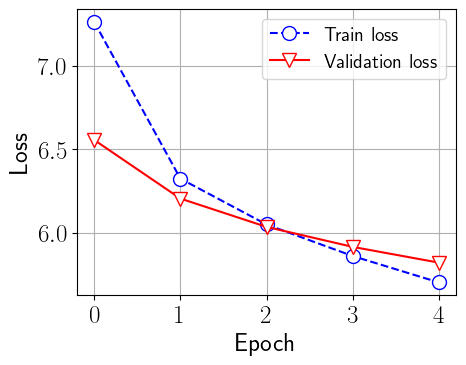

In [89]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
marker = ["o", "v"]
color = ["blue", "red"]
linestyle = ["--", "-"]
markerfacecolor = ["white", "white"]
markersize = 10
grid = True
ax.plot(train_loss, label="Train loss", marker=marker[0], color=color[0], linestyle=linestyle[0], markerfacecolor=markerfacecolor[0], markersize=markersize)
ax.plot(val_loss, label="Validation loss", marker=marker[1], color=color[1], linestyle=linestyle[1], markerfacecolor=markerfacecolor[1], markersize=markersize)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend(fontsize=14)
plt.grid(grid)
plt.tight_layout()
plt.show()

🚧 **Question** 🚧

Plot the training and validation curves. What can you conclude from those curves?

**Answer**

The models seems to learn quite quickly during the first epoch, but the learning speeds slows down a lot after. This means that there is not enough data to infer accurate semantic meaning. Therefore the model seems to need much more data to reach it full potential.

🚧 **TODO** 🚧

Implement an greedy decoding algorithm. And use it on your model.

In [96]:
output_tokens = []
model.eval()
input_sentence = "UCB is an algorithm for bandit problems."
print("Input text:", input_sentence)
tokenized_sentence = tokenizer.encode(input_sentence, add_special_tokens=False)

# Add the bos token
tokenized_sentence = [tokenizer.bos_token_id] + tokenized_sentence
input_ids = torch.tensor([tokenized_sentence])
attention_mask = torch.ones_like(input_ids)
print("Input tensor:", input_ids)
with torch.no_grad():
    for i in range(50):
        logits = model(input_ids.to(device), attention_mask.to(device))
        next_token = torch.argmax(logits[0, -1]).item()
        input_ids = torch.cat((input_ids, torch.tensor([next_token])[None, :]), dim=-1)
        attention_mask = torch.ones_like(input_ids)
        print(tokenizer.decode(input_ids[0]))

Input text: UCB is an algorithm for bandit problems.
Input tensor: tensor([[    0, 12945,   387,    16,    41, 17194,    13,  1971,   405,  1272,
             4]])
<s>UCB is an algorithm for bandit problems. The
<s>UCB is an algorithm for bandit problems. The film
<s>UCB is an algorithm for bandit problems. The film,
<s>UCB is an algorithm for bandit problems. The film, and
<s>UCB is an algorithm for bandit problems. The film, and the
<s>UCB is an algorithm for bandit problems. The film, and the film
<s>UCB is an algorithm for bandit problems. The film, and the film.
<s>UCB is an algorithm for bandit problems. The film, and the film. The
<s>UCB is an algorithm for bandit problems. The film, and the film. The acting
<s>UCB is an algorithm for bandit problems. The film, and the film. The acting,
<s>UCB is an algorithm for bandit problems. The film, and the film. The acting, and
<s>UCB is an algorithm for bandit problems. The film, and the film. The acting, and the
<s>UCB is an algorithm 